## Adtech Data Analysis
This task focuses on **analyzing the AD-Tech dataset derived from an advertising platform**. In the world of digital advertising, **it's crucial to understand how various factors affect ad performance**. Proper ad placement and targeting can greatly improve user engagement and, as a result, increase revenue.<br> 

 This dataset offers a detailed look at ad performance metrics. The dataset encapsulates daily metrics related to advertisements served across various websites, advertisers, geographic localization, capturing details like impressions, viewability, and revenue generated.<br>

 **The goal is to develop a predictive model that can predict total revenue** from advertisements. We will utilize both **traditional Machine Learning (ML)** techniques and **Artificial Neural Network (ANN)** models to predict the same outcome.<br>

 To get insights from the dataset, we are conducting an **Exploratory Data Analysis (EDA)**, this includes examining distributions of key metrics, identifying patterns, and getting a better understanding about the relationships between features. Also, it will be focused on apply **Feature Engineering** to enhance model's performance

In [43]:
#Import required modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from joblib import dump




# Data Preprocessing

In [44]:
df_adtech = pd.read_csv('AD-Tech.csv')
df_adtech.head()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,30-06-2019 00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1
1,30-06-2019 00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1
2,30-06-2019 00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1
3,30-06-2019 00:00,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0,0,4,1
4,30-06-2019 00:00,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0,0,4,1


Some questions:
1. The revenue_share_percent is related to which identifier(share by site, share by advertiser, etc...)?
2. About the identifiers what is: line_item_type, order, ad_unit, integration_type? Order and ad_unit Check

In [45]:
df_adtech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     567291 non-null  object 
 1   site_id                  567291 non-null  int64  
 2   ad_type_id               567291 non-null  int64  
 3   geo_id                   567291 non-null  int64  
 4   device_category_id       567291 non-null  int64  
 5   advertiser_id            567291 non-null  int64  
 6   order_id                 567291 non-null  int64  
 7   line_item_type_id        567291 non-null  int64  
 8   os_id                    567291 non-null  int64  
 9   integration_type_id      567291 non-null  int64  
 10  monetization_channel_id  567291 non-null  int64  
 11  ad_unit_id               567291 non-null  int64  
 12  total_impressions        567291 non-null  int64  
 13  total_revenue            567291 non-null  float64
 14  view

It is notable that the dataset does not present missing values, there aren't categorical columns, the most of the columns are int type, with only one float and one timestamp column, we can also see that the most of the columns are identifiers, the dataset present 17 columns and only 6 aren't id columns

About the impression features:
- Total impressions: The total times a ad was served
- Measurable impressions: From the total impressions how much it was possible to measure if the ad was seen(sometimes is not posible to measure due to ad blocks or connectivity problems)
- Viewable impressions: From the measurable impressions, how much were actually seen by a user(the ad appeared in the visible portion of their browser window)

So, it should be no register presenting viewable impressions higher than measurable impressions or total impressions, or measurable impressions higher than total impression

In [46]:
non_hierarchical_data = df_adtech[
    (df_adtech['viewable_impressions'] > df_adtech['measurable_impressions']) |
    (df_adtech['measurable_impressions'] > df_adtech['total_impressions']) |
    (df_adtech['viewable_impressions'] > df_adtech['total_impressions'])
]

non_hierarchical_data.shape

(2184, 17)

This 2183 rows present non-sense data so it will be droped from the dataframe

In [47]:
df_adtech = df_adtech.drop(index = non_hierarchical_data.index)

In [48]:
print(df_adtech.shape)
print(df_adtech.drop_duplicates().shape)
df_adtech = df_adtech.drop_duplicates()

(565107, 17)
(541944, 17)


There are some repeated lines, so we've eliminated them to reduce useless information

In [49]:
#Getting the stats of the columns
identifiers = [col for col in df_adtech.columns if col.endswith("_id")]
df_adtech.drop(columns=identifiers).describe() #Drop the id columns because they have no statistical relevance 

,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
count,541944.000000,541944.000000,541944.000000,541944.000000,541944.0
mean,34.874267,0.072437,13.041037,33.287281,1.0
std,225.606756,0.728430,103.566473,211.508472,0.0
min,0.000000,-0.154200,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,1.0
50%,2.000000,0.000000,0.000000,2.000000,1.0
75%,6.000000,0.006000,2.000000,6.000000,1.0
max,14452.000000,83.822000,7392.000000,13756.000000,1.0


We can notice that the revenue share percent is a column with value 1 for all the registers, this may show an potential error in our dataset once it does not make sense to present this value

In [50]:
df_adtech.drop(columns='revenue_share_percent', inplace=True)

In [51]:
print(df_adtech['date'].min())
print(df_adtech['date'].max())

01-06-2019 00:00
30-06-2019 00:00


The dataset cover the month of june 2019

# Exploratory Data Analysis

In [52]:
sns.set(style="whitegrid")

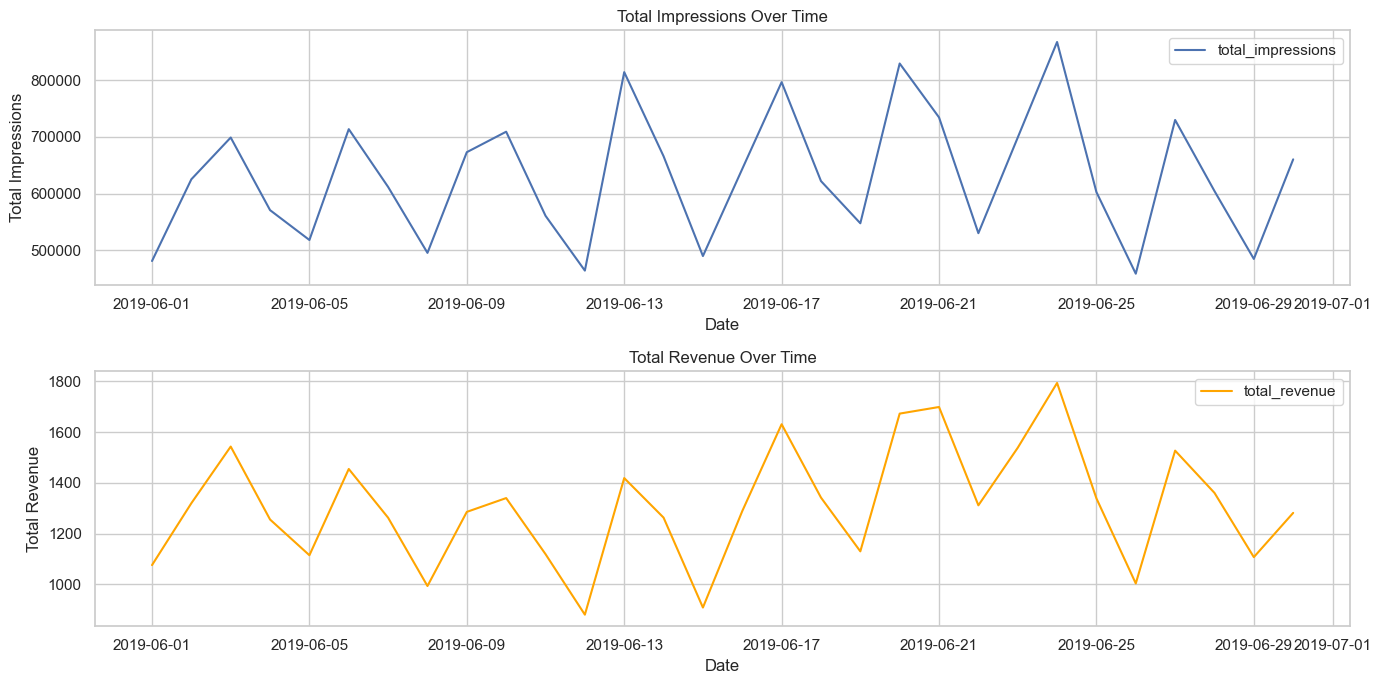

In [53]:
df_adtech['date'] = pd.to_datetime(df_adtech['date'], format='%d-%m-%Y %H:%M') # Convert date column

# Temporal Analysis: Total Impressions and Revenue over Time
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
df_adtech.groupby(df_adtech['date'].dt.date)['total_impressions'].sum().plot(kind='line', legend=True)
plt.title('Total Impressions Over Time')
plt.xlabel('Date')
plt.ylabel('Total Impressions')

plt.subplot(2, 1, 2)
df_adtech.groupby(df_adtech['date'].dt.date)['total_revenue'].sum().plot(kind='line', color='orange', legend=True)
plt.title('Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.show()

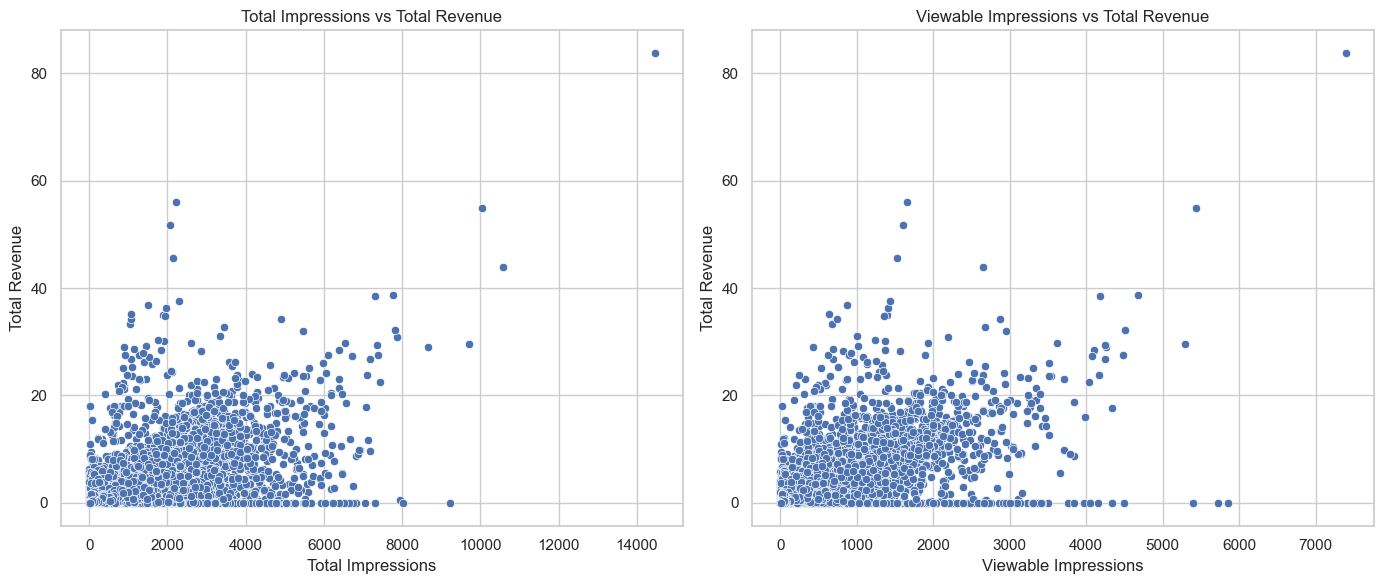

In [54]:
# Revenue Analysis - Relationship between Total Impressions and Total Revenue
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x='total_impressions', y='total_revenue', data=df_adtech, ax=axes[0])
axes[0].set_title('Total Impressions vs Total Revenue')
axes[0].set_xlabel('Total Impressions')
axes[0].set_ylabel('Total Revenue')

sns.scatterplot(x='viewable_impressions', y='total_revenue', data=df_adtech, ax=axes[1])
axes[1].set_title('Viewable Impressions vs Total Revenue')
axes[1].set_xlabel('Viewable Impressions')
axes[1].set_ylabel('Total Revenue')

plt.tight_layout()
plt.show()



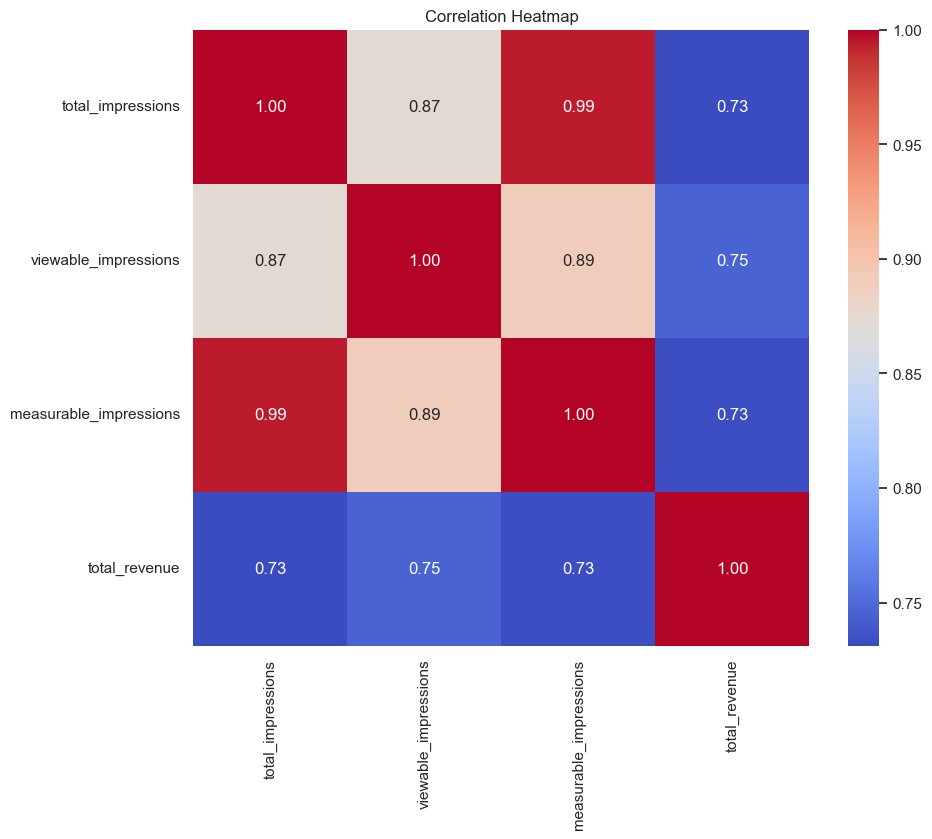

In [55]:
# Correlation Heatmap
correlation_matrix = df_adtech[['total_impressions', 'viewable_impressions', 'measurable_impressions', 'total_revenue']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, )
plt.title('Correlation Heatmap')
plt.show()

plotly - heatmap

This plot shows that the total revenue has a high correlation with all other columns, the viewable impressions present a slight advantage in this metric, which makes sense, since it's the ads seen that generate clicks and therefore resale value

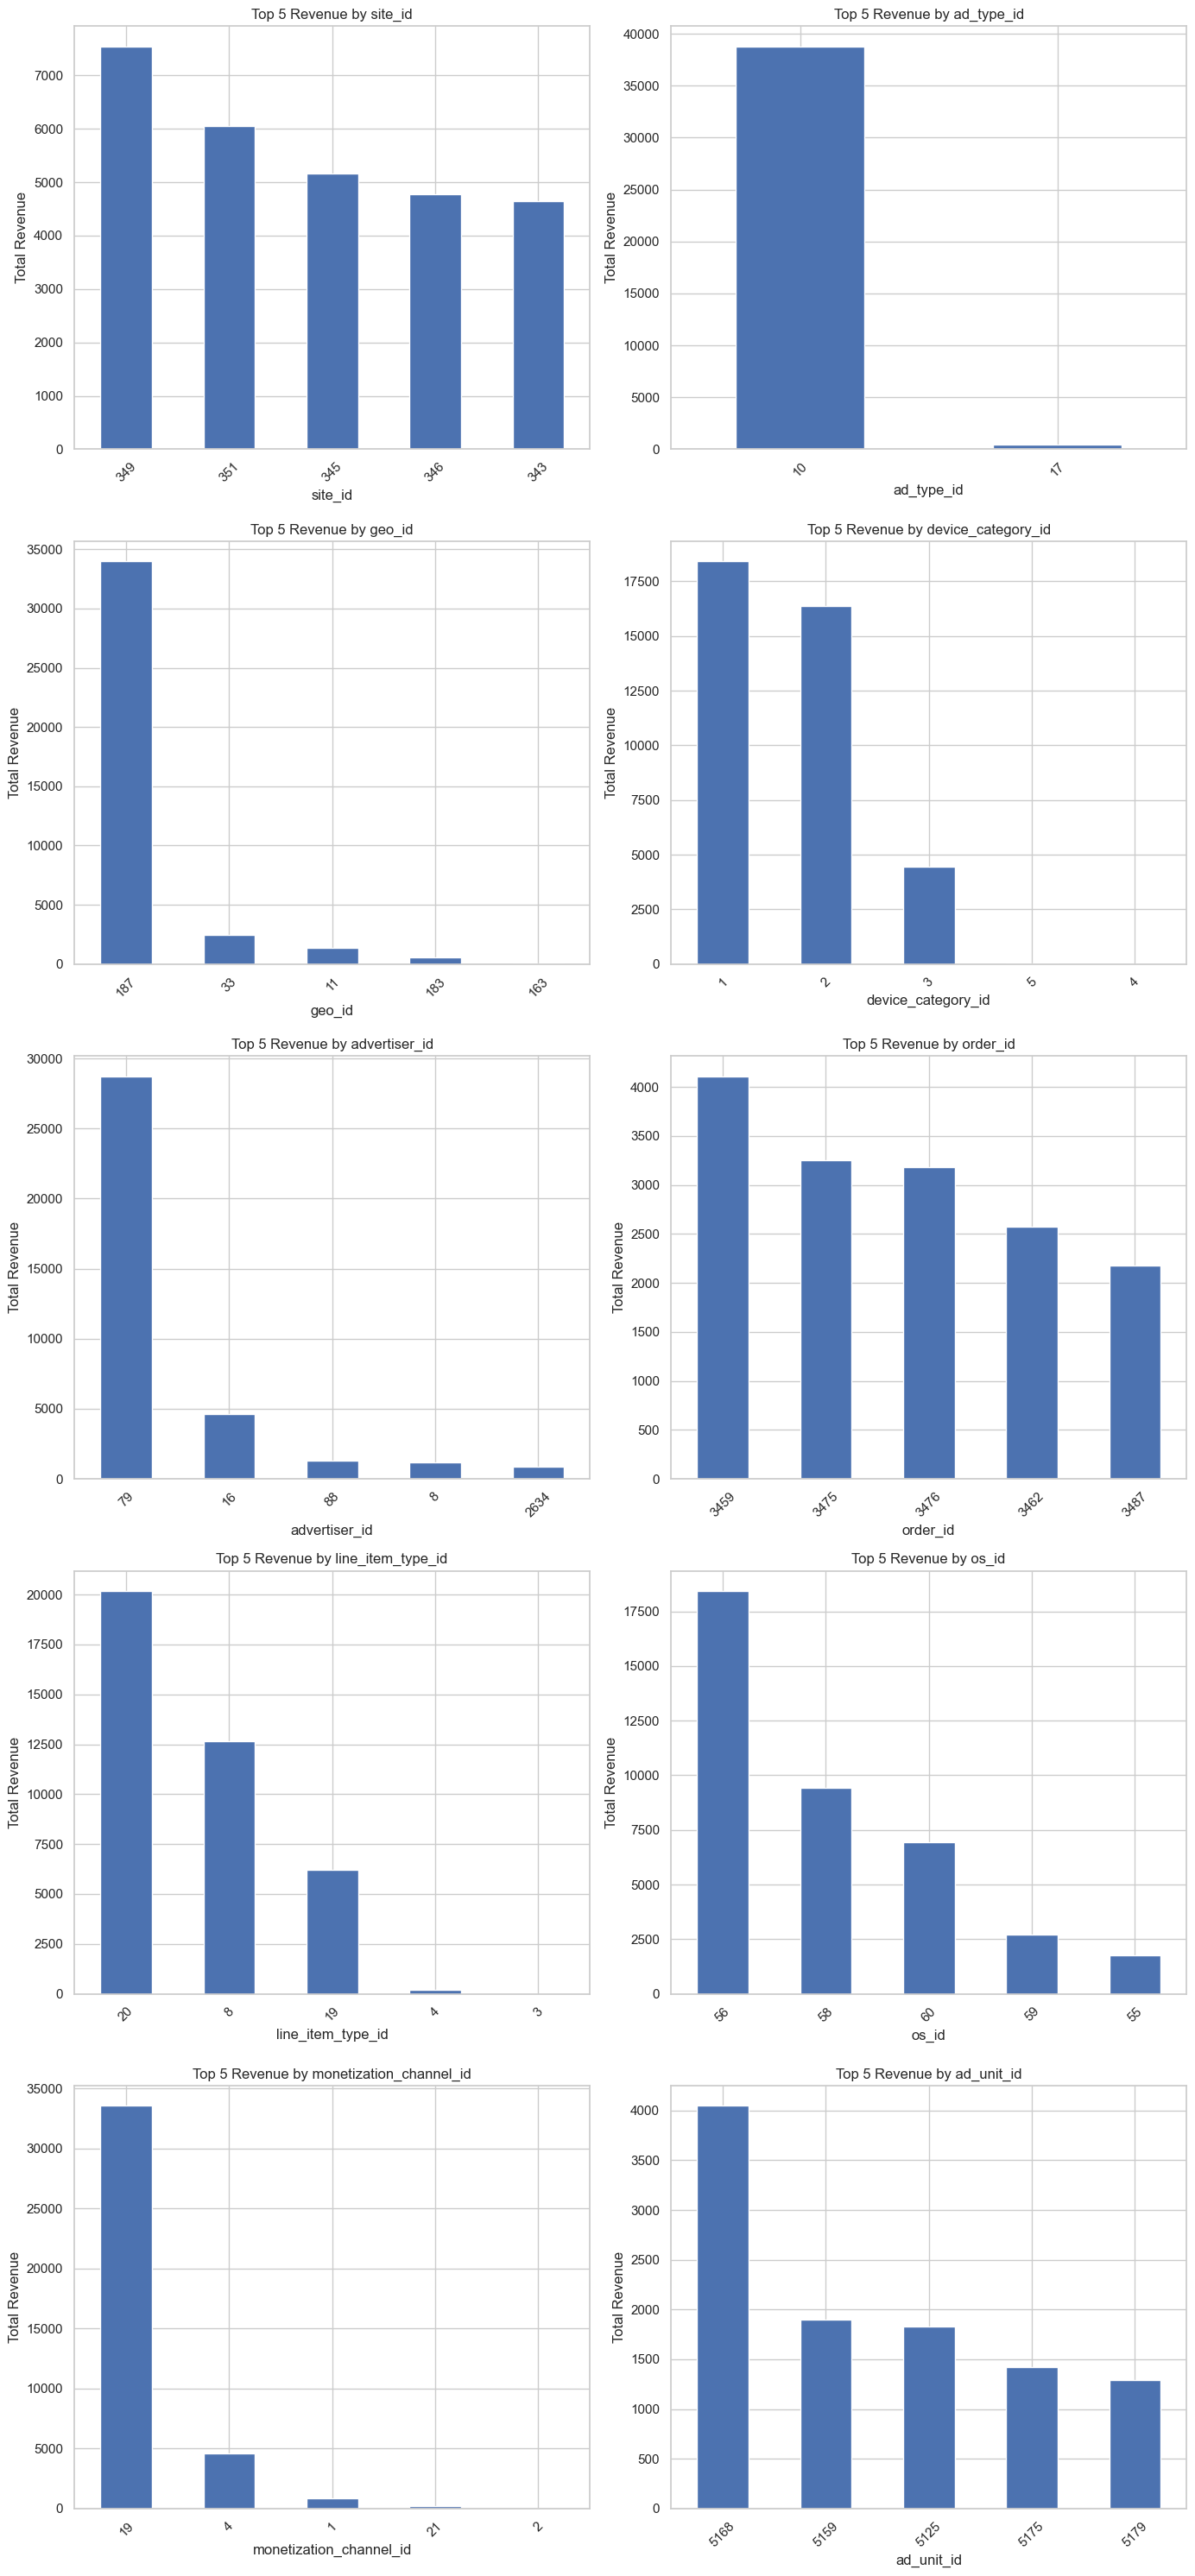

In [56]:
#Getting the top revenue by each identifier column

def plot_top_revenue_by_id(df, id_columns, num_top=5):
    # Set the number of subplots based on the number of identifier columns
    num_subplots = len(id_columns)
    
    # Calculate the number of rows/columns for the subplots
    num_rows = -(-num_subplots // 2)  # Ceiling division to get rows needed
    num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 6))
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    # Loop through each identifier column and create a plot
    for i, id_col in enumerate(id_columns):
        top_revenues = df.groupby(id_col)['total_revenue'].sum().sort_values(ascending=False).head(num_top)
        top_revenues.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Top {num_top} Revenue by {id_col}')
        axes[i].set_xlabel(id_col)
        axes[i].set_ylabel('Total Revenue')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Hide axes if there are any extra ones
        if i >= num_subplots:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# List of identifier columns
id_columns = [
    'site_id',
    'ad_type_id',
    'geo_id',
    'device_category_id',
    'advertiser_id',
    'order_id',
    'line_item_type_id',
    'os_id',
    'monetization_channel_id',
    'ad_unit_id'
]

# Call the function with the dataframe and identifier columns
plot_top_revenue_by_id(df_adtech, id_columns)

This plot shows the top revenue for each identifier, so we can see that:
- **Site**: 349, 351 and 345 are the top 3 and the decrease trend seems to be linear.
- **Advertise Type**: The type 10 is way bigger in revenue than 17.
- **Geographic Loc.**: 187 have much higher revenues than all the others, followed by 33 and 11.
- **Device Category**: For this category, devices 2 and 1 clearly have the highest amount of revenue followed by 3, the devices 4 and 5 does not present any revenue value.
- **Advertiser**: Advertiser 79 is having significantly higher revenues compared to others, followed by 80 and 82 but with a marked difference.
- **Order**: order 3473 shows the highest revenue, followed by 3476 and 3484.
- **Line Item Type**: Line item type 19 is the most profitable, while type 20 has less than half the revenue of type 19, indicating a possible preference or better performance of type 19 in campaigns.
- **OS**: Operating system 58 brings in the most revenue by a considerable margin, followed by OS 59 and 60, hinting that users of OS 58 are either more numerous or more engaged with ads.
- **Monetization Channel**: Channel 4 overwhelmingly outperforms others in terms of revenue. This channel might represent a more successful monetization strategy or a popular method among users.
- **Ad Unit**: Ad unit 5174 generates the highest revenue, with units 5168, 5175, and 5176 also showing significant contributions but with a decreasing trend.

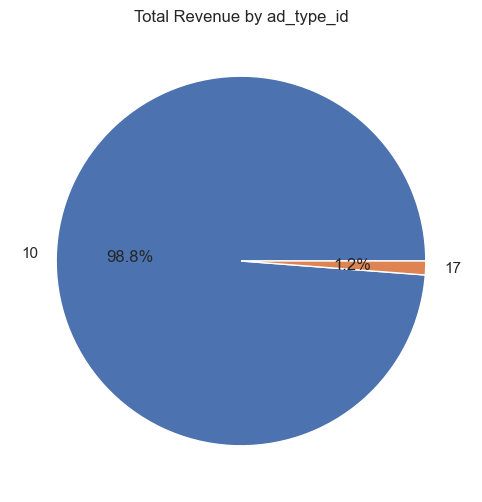

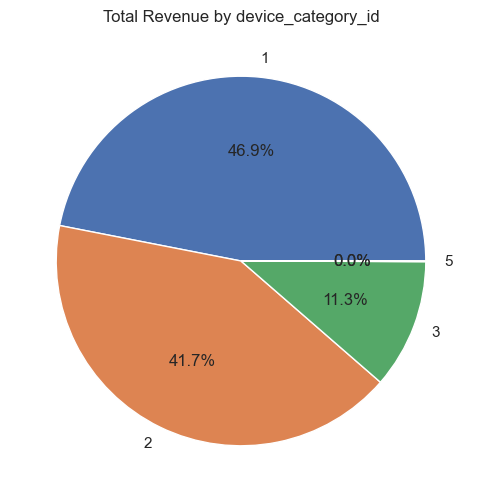

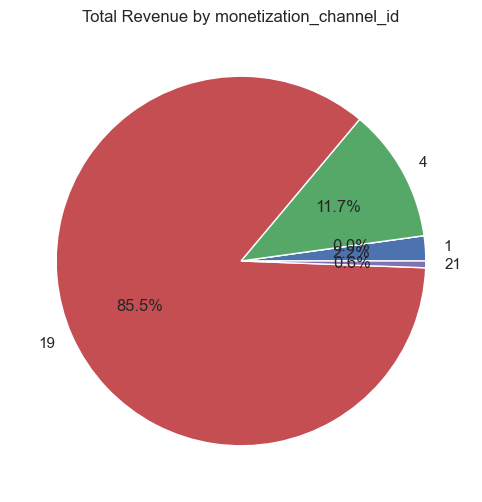

In [57]:
# Few Categories Analysis
few_categories_col = []
for col in df_adtech.columns:
    values = df_adtech[col].drop_duplicates().values
    if(len(values)<6 and col != 'integration_type_id' and col != 'revenue_share_percent'):
        few_categories_col.append(col)

for col in few_categories_col:
    plt.figure(figsize=(12, 6))
    df_adtech.groupby(col)['total_revenue'].sum().plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Total Revenue by {col}')
    plt.ylabel('')  # Hide y-label for cleaner look
    plt.show()

This allow us to have a better understanding of the concentration of impressions for the features with few categories

Use pie-chart only in one-against all cases - search new york time guide about how to do plots

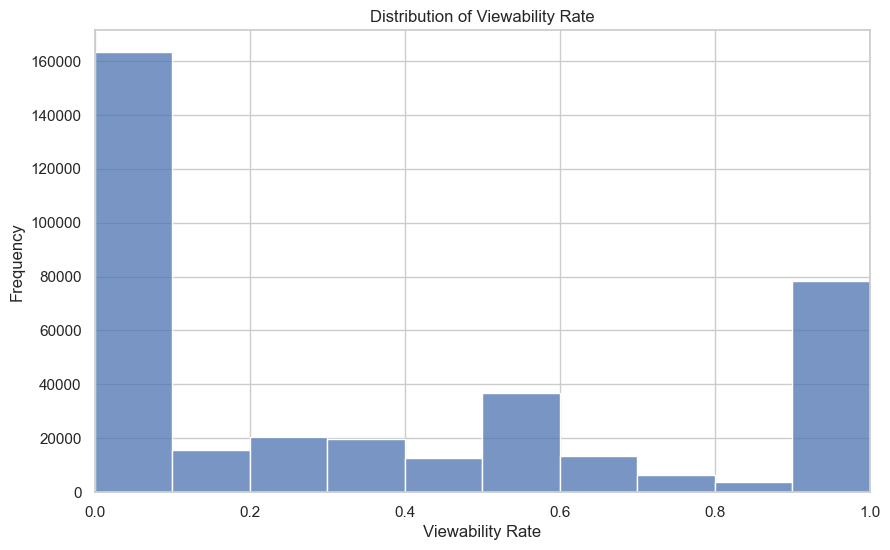

In [58]:
# Impression Analysis - Viewability Rate (Viewable/Total Impressions)
viewability_rate = df_adtech['viewable_impressions'] / df_adtech['total_impressions']
plt.figure(figsize=(10, 6))
sns.histplot(viewability_rate.dropna(), kde=False, bins = 10)
plt.title('Distribution of Viewability Rate')
plt.xlabel('Viewability Rate')
plt.ylabel('Frequency')
plt.xlim([0,1])
plt.show()


This plot is an indicate that the viewability rate for the most of the advertises are low, the rate in the range of 0.1 is more than the double of the viewability in the range of 0.9 to 1.0

Now we are going to evaluate the time influence over the impressions and revenue, the approach will be to understand how this metrics behave on different weekdays and compare the weekend vs weekday performance 

In [59]:
df_adtech['weekday'] = df_adtech['date'].dt.day_name()
df_adtech['is_weekend'] = df_adtech['date'].dt.weekday.isin([5, 6]).astype(int)

In [60]:
df_adtech

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,weekday,is_weekend
0,2019-06-30,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0000,2,16,Sunday,1
1,2019-06-30,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0000,0,6,Sunday,1
2,2019-06-30,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0000,0,4,Sunday,1
3,2019-06-30,351,10,147,2,84,3473,19,58,1,4,5174,4,0.0000,0,4,Sunday,1
4,2019-06-30,348,10,147,3,79,3463,20,59,1,19,5138,4,0.0000,0,4,Sunday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567286,2019-06-01,350,10,187,3,79,3456,20,59,1,19,5168,12,0.0254,4,12,Saturday,1
567287,2019-06-01,350,10,187,1,79,3456,20,56,1,19,5168,68,0.3400,52,66,Saturday,1
567288,2019-06-01,350,10,158,1,79,3456,20,56,1,19,5168,2,0.0046,0,2,Saturday,1
567289,2019-06-01,350,10,33,1,79,3456,20,56,1,19,5168,6,0.0120,0,6,Saturday,1


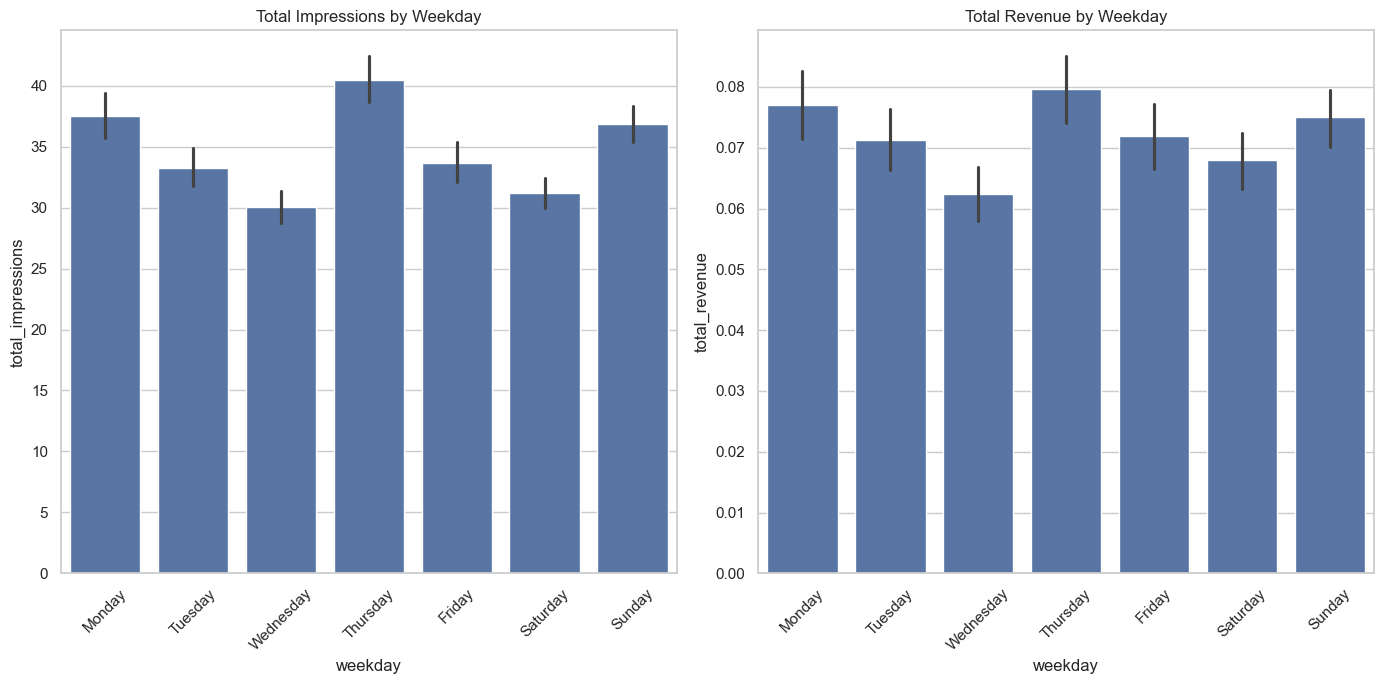

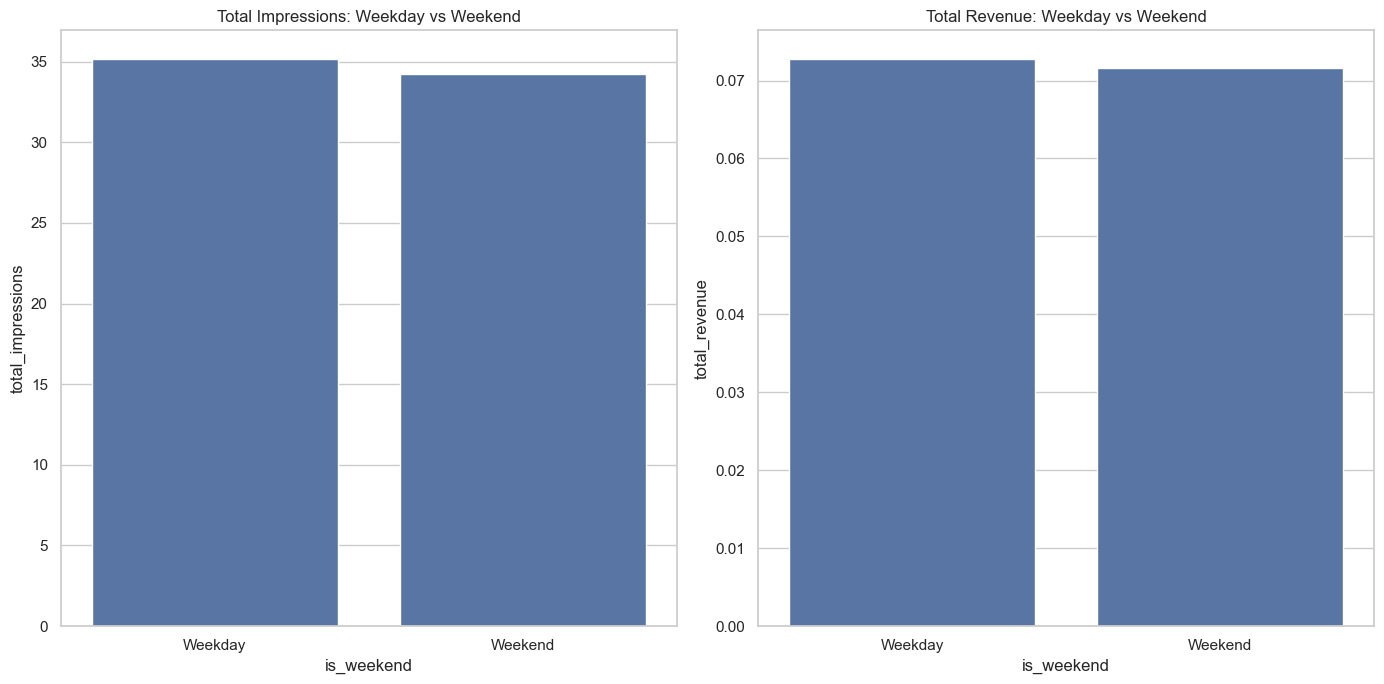

In [61]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='weekday', y='total_impressions', data=df_adtech, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Total Impressions by Weekday')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='weekday', y='total_revenue', data=df_adtech, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Total Revenue by Weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x='is_weekend', y='total_impressions', data=df_adtech[['total_impressions','is_weekend']].groupby('is_weekend').mean()) 
#In the weekday vs weekend analysis it is used the mean value, once there are more week days than weekend days
plt.title('Total Impressions: Weekday vs Weekend')
plt.xticks([0, 1], ['Weekday', 'Weekend'])

plt.subplot(1, 2, 2)
sns.barplot(x='is_weekend', y='total_revenue', data=df_adtech[['total_revenue','is_weekend']].groupby('is_weekend').mean())
plt.title('Total Revenue: Weekday vs Weekend')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.tight_layout()

plt.show()


- For the week day anaylsis it can be observed that there is a small increase in revenue and impressions on Thursdays and a small decrease on Wednesday and Saturday.
- For the weekday vs weekend, the performance is almost the same.

# Machine Learning Model

Now we are going to build the model to predict the total revenue of each ads, for this process, is important first to do a feature selection, to keep only the features that present more influence for in the predictions

Let's start by dealing with the identifier columns, since, as identifier columns, they don't have a significant value for our model, we'll convert them into categorical characteristics and present different strategies for doing so based on cardinality

In [62]:
for col in identifiers:
    print(f"Column: {col} - No. of values: {len(df_adtech[col].drop_duplicates().values)}")

Column: site_id - No. of values: 10
Column: ad_type_id - No. of values: 2
Column: geo_id - No. of values: 219
Column: device_category_id - No. of values: 5
Column: advertiser_id - No. of values: 23
Column: order_id - No. of values: 75
Column: line_item_type_id - No. of values: 7
Column: os_id - No. of values: 7
Column: integration_type_id - No. of values: 1
Column: monetization_channel_id - No. of values: 5
Column: ad_unit_id - No. of values: 132


In [63]:
low_cardinality_cols = [col for col in identifiers if df_adtech[col].nunique() <= 10]
high_cardinality_cols = [col for col in identifiers if df_adtech[col].nunique() > 10]

The integration type id it is a columns with only one value so it's irrelevant 

In [64]:
df_adtech = df_adtech.drop(columns='integration_type_id')
identifiers.remove('integration_type_id')

So, the columns with low cardinality(less than 10 unique values) we are going to target encode, the features with high cardinality we are going to perform label encoding

The geo_id column is has the feature with higher cardinality, with almost the double of categories than the second higher cardinality column, in this case, it isn't a good idea to treat it as a categorical feature, so it will be divided into 4 geographic regions based on it revenue value

In [65]:
mean_revenues = df_adtech.groupby('geo_id')['total_revenue'].mean()
quantiles = mean_revenues.quantile([0.25, 0.5, 0.75])

In [66]:
def revenue_to_category(revenue):
    if revenue <= quantiles[0.25]:
        return 0 #Low Revenue Region
    elif revenue <= quantiles[0.5]:
        return 1 #Medium-Low Revenue Region
    elif revenue <= quantiles[0.75]:
        return 2 #Medium-High Revenue Region
    else:
        return 3 #High Revenue Region

# Map the mean revenues of each geo_id to its corresponding category
df_regions_revenue = mean_revenues.map(revenue_to_category).reset_index()
df_regions_revenue = df_regions_revenue.rename(columns={'total_revenue': 'revenue_geo_region'})
df_adtech = df_adtech.merge(df_regions_revenue, on='geo_id')
df_adtech = df_adtech.drop(columns='geo_id')
identifiers.remove('geo_id')

Let's ordinal encode also the weekday feature

In [67]:
weekday_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Apply the mapping to the 'weekday' column
df_adtech['weekday'] = df_adtech['weekday'].map(weekday_mapping)

In [68]:
high_cardinality_cols.remove('geo_id')
print(high_cardinality_cols)
for col in high_cardinality_cols:
    le = LabelEncoder()
    df_adtech[col] = le.fit_transform(df_adtech[col])
    dump(le, f'model_encoders/{col}_label_encoder.joblib')


['advertiser_id', 'order_id', 'ad_unit_id']


target encoding it would be a good approach
study more about which encoding tecnique to use

Before applying Target Encoding, we are going to split your data into training and test sets, this prevents information about the distribution of the target in the test set from leaking into your model during the encoding process.

In [69]:
X = df_adtech.drop(columns=['date','total_revenue'])
y = df_adtech['total_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
low_cardinality_cols.remove('integration_type_id')

encoder = ce.TargetEncoder(cols=low_cardinality_cols)
X_train[low_cardinality_cols] = encoder.fit_transform(X_train[low_cardinality_cols], y_train)
X_test[low_cardinality_cols] = encoder.transform(X_test[low_cardinality_cols])
dump(encoder, 'model_encoders/target_encoder.joblib')



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/category_encoders/

['model_encoders/target_encoder.joblib']

Now, that we handled the identifier columns, let's check the correlation of the features in order to do feature selection

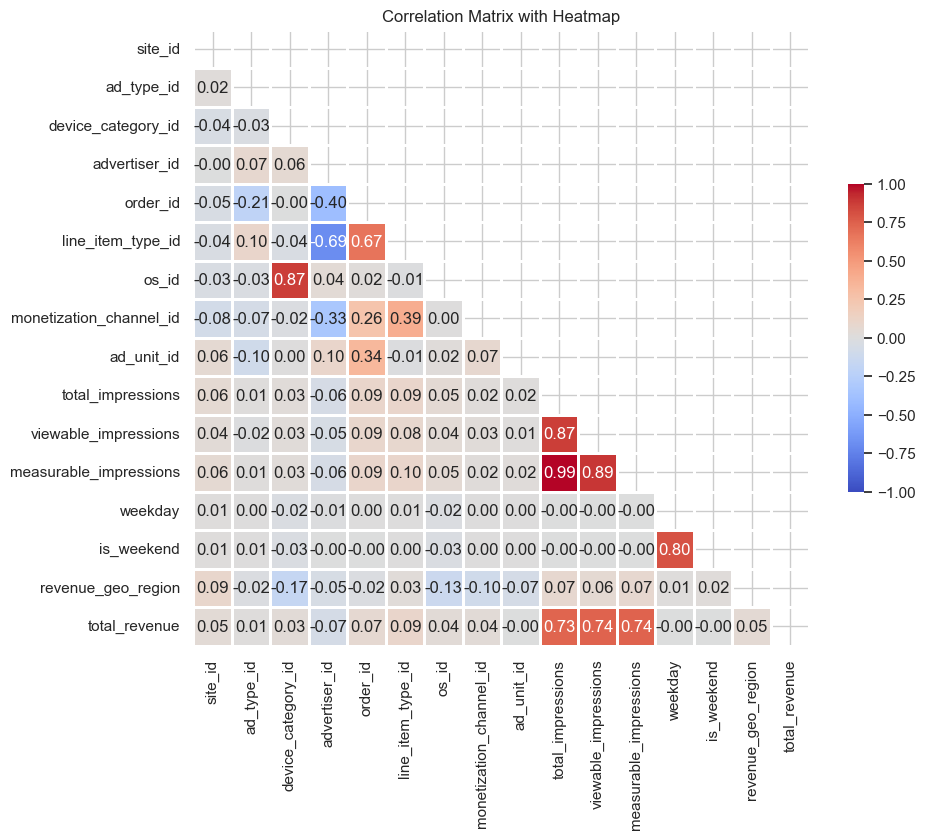

In [71]:
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=1, vmin=-1, center=0, square=True, linewidths=.9, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix with Heatmap')
plt.show()


Let's drop the columns that presented the worst correlation to the total revenue(revenenue_geo_region it was droped because it depends on the target value):

In [72]:
X_train = X_train.drop(columns=['weekday','is_weekend', 'ad_unit_id', 'revenue_geo_region'])
X_test = X_test.drop(columns=['weekday','is_weekend', 'ad_unit_id', 'revenue_geo_region'])

In [73]:
# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
dump(model, 'model_encoders/LR_model.joblib')

# Predicting the test results
y_pred_ml = model.predict(X_test)

# Evaluating the model
mse_ml = mean_squared_error(y_test, y_pred_ml)
mae_ml = mean_absolute_error(y_test, y_pred_ml)
r2_ml = r2_score(y_test, y_pred_ml)

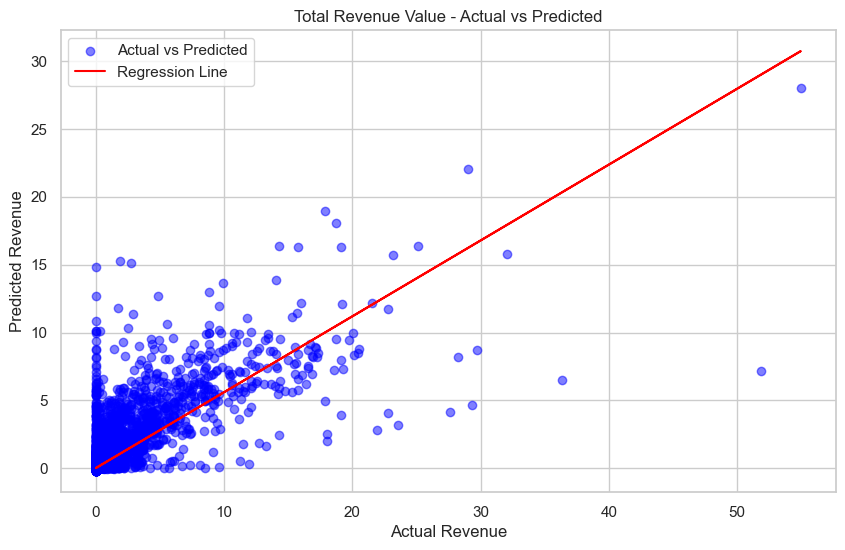

MSE:0.20432079917813342
MAE:0.06759111982093564
R2 Score:0.5976076912457262


In [74]:
# Assuming y_test and y_pred are defined from your model predictions
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ml, color='blue', label='Actual vs Predicted', alpha=0.5)  # Scatter plot of actual vs predictions

model_slope, model_intercept = np.polyfit(y_test, y_pred_ml, 1)
plt.plot(y_test, model_slope*y_test + model_intercept, color='red', label='Regression Line')  # Regression line

plt.title('Total Revenue Value - Actual vs Predicted')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.legend()
plt.grid(True)
plt.show()

print(f"MSE:{mse_ml}\nMAE:{mae_ml}\nR2 Score:{r2_ml}")


# Artificial Neural Network Model

Artificial Neural Networks can be very sensitive to different scale features, so we are going to first apply a normalization method

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

normalize_columns = ['monetization_channel_id',	'total_impressions','viewable_impressions','measurable_impressions']
X_train[normalize_columns] = scaler.fit_transform(X_train[normalize_columns])
X_test[normalize_columns] = scaler.fit_transform(X_test[normalize_columns])


In [76]:
n_features = X_train.shape[1]

model = Sequential()
model.add(Dense(32, activation='leaky_relu', input_shape=(n_features,)))
model.add(Dense(16, activation='leaky_relu'))
model.add(Dense(1, activation='linear'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [77]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=256, verbose=1)


Epoch 1/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 1s 237us/step - loss: 1.2137
Epoch 2/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 0.3183
Epoch 3/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss: 0.2359
Epoch 4/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 0.1897
Epoch 5/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 0.1980
Epoch 6/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 0.1771
Epoch 7/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 0.1889
Epoch 8/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - loss: 0.1854
Epoch 9/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 0.1772
Epoch 10/10
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 0.1828


In [78]:
# Evaluating the model on test data
y_pred_nn = model.predict(X_test).flatten()

# Calculating the evaluation metrics
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)


3388/3388 ━━━━━━━━━━━━━━━━━━━━ 1s 163us/step


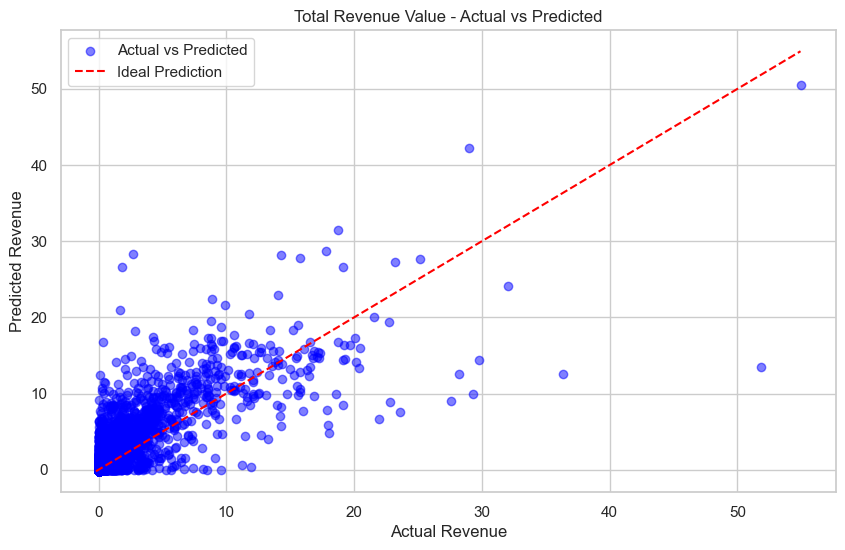

MSE:0.25591634541229064
MAE:0.10116017353653048
R2 Score:0.49599468339673214


In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5, color='blue', label='Actual vs Predicted')
plt.title('Total Revenue Value - Actual vs Predicted')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')

# Plot the identity line
max_value = max(y_test.max(), y_pred_nn.max())
min_value = min(y_test.min(), y_pred_nn.min())
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Ideal Prediction')

plt.legend()
plt.grid(True)
plt.show()

print(f"MSE:{mse_nn}\nMAE:{mae_nn}\nR2 Score:{r2_nn}")
